<a href="https://colab.research.google.com/github/NodiraTillayeva/ERA5Analysis/blob/main/ParseNC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parsing netcdf files with python


In [3]:
%pip install numpy pandas xarray netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.2 MB/s eta 0:00:00


In [4]:
import netCDF4 as nc
import pandas as pd
from datetime import datetime

In [5]:
# Replace with your .nc file path
nc_file = '/content/travka.nc'

In [6]:
# Open the NetCDF file
ds = nc.Dataset(nc_file)

In [7]:
# List all variables
print("Variables in the file:")
for var in ds.variables:
    print(var)

Variables in the file:
longitude
latitude
expver
time
lai_hv
lai_lv


In [24]:
# Extract data
# Assuming variable names are 'time', 'latitude', 'longitude', 'low_veg_index', 'high_veg_index'
# Modify as per your file's variable names
times = ds.variables['time'][:]
lats  = ds.variables['latitude'][:]
lons  = ds.variables['longitude'][:]
low_veg  = ds.variables['lai_lv'][:]
high_veg  = ds.variables['lai_hv'][:]

In [ ]:
# Prepare a list to hold the data
data = []

# Iterate over each time, latitude, and longitude
for time_index, time_value in enumerate(times):
    for lat_index, lat_value in enumerate(lats):
        for lon_index, lon_value in enumerate(lons):
            # Check if indices are within the bounds of the low_veg and high_veg arrays
            if lat_index < low_veg.shape[1] and lon_index < low_veg.shape[2]:
                # Extracting values for low and high vegetation at this point
                low_veg_value = low_veg[time_index, lat_index, lon_index]
                high_veg_value = high_veg[time_index, lat_index, lon_index]

                # Appending to the data list
                data.append([time_value, lat_value, lon_value, low_veg_value, high_veg_value])

# Convert to DataFrame
df = pd.DataFrame(data, columns=['Time', 'Latitude', 'Longitude', 'Low Vegetation', 'High Vegetation'])

# Save to CSV
csv_file_path = 'output_data.csv'
df.to_csv(csv_file_path, index=False)

# Close the NetCDF file
dataset.close()

In [27]:
ds.close()

In [44]:
df.tail()

,Time,Latitude,Longitude,Low Vegetation,High Vegetation
150615,1084752,45.48,63.99,1.318490,[2.098176339234622 2.097805767645213 1.8193582...
150616,1084752,45.48,64.09,1.219858,[1.7616973360511117 0.5423685782592356 2.04488...
150617,1084752,45.48,64.19,1.285331,[2.1676955694077793 1.2752850677926577 1.25008...
150618,1084752,45.48,64.29,1.129772,[1.9352730685303587 1.927268722199121 1.803942...
150619,1084752,45.48,64.39,0.854929,[-4.440892098500626e-16 -4.440892098500626e-16...


In [30]:
%pip install matplotlib geopandas

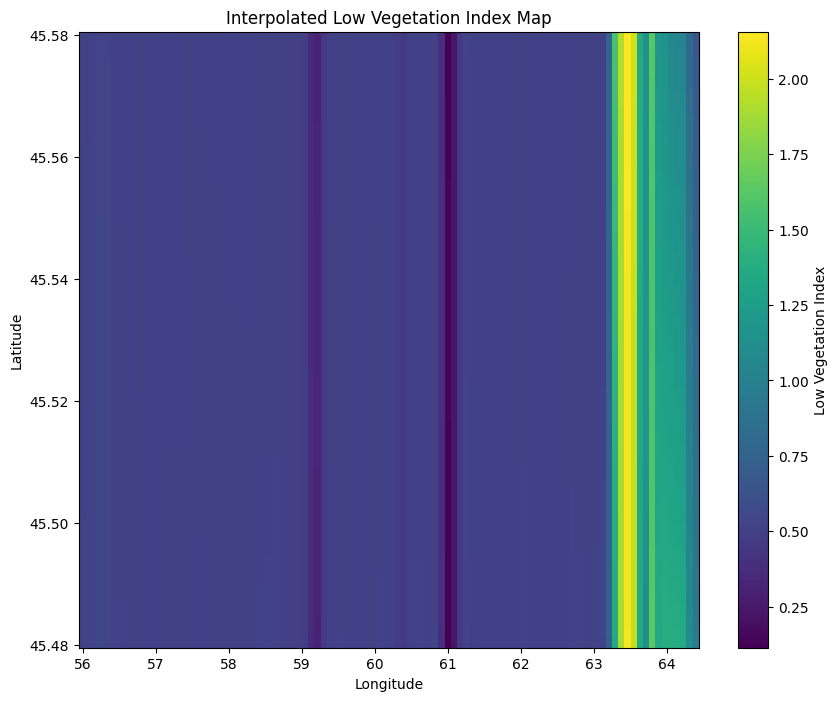

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Load the data
df = pd.read_csv('output_data.csv')

# Pre-process the data: replace '--' with NaN, extract the first element of the low vegetation array
df['Low Vegetation'] = df['Low Vegetation'].apply(lambda x: np.nan if '--' in x else float(x.strip('[]').split()[0]))

# Drop NaN values to avoid issues during interpolation
df = df.dropna(subset=['Low Vegetation'])

# Create grid coordinates for interpolation
grid_lon = np.linspace(df['Longitude'].min(), df['Longitude'].max(), 100)  # Adjust 100 to your desired resolution
grid_lat = np.linspace(df['Latitude'].min(), df['Latitude'].max(), 100)    # Adjust 100 to your desired resolution
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

# Interpolate data
grid_veg = griddata(
    points=(df['Longitude'], df['Latitude']),
    values=df['Low Vegetation'],
    xi=(grid_lon, grid_lat),
    method='cubic'  # 'linear', 'nearest' and 'cubic' are some options
)

# Plotting
plt.figure(figsize=(10, 8))
plt.pcolormesh(grid_lon, grid_lat, grid_veg, shading='auto', cmap='viridis')
plt.colorbar(label='Low Vegetation Index')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated Low Vegetation Index Map')
plt.show()
